This function demonstrates the impact of Concomitant (Maxwell) fields on a diffusion encoding gradient.

Questions
  1. Design a gradient waveform with an effective b-value of 1000 s/mm^2 that does not point along the x-direction 
     - Do this without changing your nucleus, gradient hardware
     - Hint: Set deltaDiff and G_dir

  2. What is the effect of imaging at 0.5T?
     - Hint: Change B0

  3. What is the effect of a 4x increase the gradient strength (Gmax) at 3T? at 0.5T?
     - Hint: Try keeping the b-value the same.

  4. EXTRA: What are the effects of concomitant fields for X-Nuclues diffusion imaging?
     - Why does the nuclues matter?
     - What kind of gradient hardware specs are preferred for diffusion imaging?
     - Is 23Na diffusion imaging harder or easier with respect to diffusion encoding?
     - Hint: Gamma for 23Na is 70.761e6 [rad/s/T]

First Python version by dbe@stanford.edu (April 2025) for Rad229

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define some system variables
B0 = 3.0  # [T]
gamma = 267.52e6 # Gyromagnetic ratio [rad/s/T]; 2*pi*42.57 MHz/T
gMax = 200e-3  # [T/m]
sMax = 200  # [T/m/s]
dt = 25e-6  # Time step [s]
dG = sMax * dt  # Gradient "step" [T/m]

# Define some acqusition variables
matrix = 256 # [integer]
fov = 0.256  # [m]
pos = np.array([-fov / 2, fov / 2, fov / 2])
X_pos = np.arange(-fov/2, fov/2 + fov/matrix, fov/matrix)
Y_pos = np.arange(-fov/2, fov/2 + fov/matrix, fov/matrix)
Y, X = np.meshgrid(X_pos, Y_pos)

# Define some diffusion encoding variables
deltaDiff = 2.1e-3  # Duration of diffusion lobe [s]
zetaDiff = gMax/sMax # Duration of diffusion ramp [s]
G_dir = np.array([1.0, 0.5, -0.5]) # Diffusion encoding direction vector
# G_unit = G_dir / np.linalg.norm(G_dir) # Diffusion encoding direction UNIT vector

In the Bloch Equation lectures we learned that gradients can sensitize the MRI signal to intravoxel spin diffusion, which is described as:

$$ S = S_0 e^{-bD} $$

S is the measured signal; S_0 is the baseline signal (without diffusion weighting); b is the "b-value" which relates to the amplitude and duration of the applied diffusion encoding gradients; and D is the voxel's diffusion coefficient.

In the next cell we use the following equation to calculate the b-value. This only applies for a bipolar traepezoidal encoding gradient. Closed-form expressions for other shapes can be found in Bernstein et al.

$$b = \gamma^2 G_{max}^2 \left[\frac{2\delta^3}{3} + \delta^2\zeta + \frac{\zeta^3}{30} - \frac{\delta\zeta^2}{6}\right]$$

<!-- # Expression for rectangular gadients -->
<!-- $$b_{val} = 2 \gamma^2 \left( g_{max} \cdot G_{dir} \right)^2 \cdot \frac{\Delta_{diff}^3}{3} \cdot 10^{-6} \quad [\text{s/mm}^2]$$ -->

In [2]:
# Generate bipolar diffusion gradient
G_rise = np.arange(0, gMax, dG)   # Gradient ramp-up
G_flat = gMax * np.ones(int(deltaDiff / dt))
G_trans = np.arange(gMax, -gMax - dG) # Gradient ramp-down
G_fall = np.arange(-gMax, 0 + dG, dG) # Gradient ramp-up
G = np.concatenate((G_rise, G_flat, G_trans, -G_flat, G_fall)) # Composite gradient waveform
tvec = np.arange(0, dt * len(G), dt)  # Time vector

# Calculate the b-value
# b_val = 2 * (gamma ** 2) * (gMax * G_dir) ** 2 * ((deltaDiff) ** 3 / 3) * 1e-6  # Rectangular bipolar gradients [s/mm^2]
b_val =  (gamma ** 2) * (gMax * G_dir) **2 * ( ((2/3)*deltaDiff**3) + (deltaDiff**2*zetaDiff) + (zetaDiff**3/30) - (deltaDiff*zetaDiff/6) ) * 1e-6 # Trap bipolar gradients [s/mm^2]
b_amp = np.linalg.norm(b_val)

# Output the b-value components...
print(f"b_x: {b_val[0]:.2f} s/mm^2")
print(f"b_y: {b_val[1]:.2f} s/mm^2")
print(f"b_z: {b_val[2]:.2f} s/mm^2")
print(f"b = {b_amp:.2f} s/mm^2")

b_x: -971.54 s/mm^2
b_y: -242.89 s/mm^2
b_z: -242.89 s/mm^2
b = 1030.48 s/mm^2


Notice that computation of the b-value (above) depends on gamma, gradient hardware, and waveform amplitude and duration!

Now we want to consider the contribution to the effective b-value owing to concomitant (Maxwell) fields. To do so we use Equation 3 from Szczepankiewicz et al. MRM 2019. (https://doi.org/10.1002/mrm.27828). Given a gradient vector $\mathbf{G}(t) = \begin{bmatrix} G_x(t) \\ G_y(t) \\ G_z(t) \end{bmatrix}$ and magnetic field strength $B_0$, the concomitant gradient matrix is:

$$
\mathbf{G_C}(t) = \frac{1}{4B_0}
\begin{bmatrix}
G_z^2(t) & 0 & -2G_x(t)G_z(t) \\
0 & G_z^2(t) & -2G_y(t)G_z(t) \\
-2G_x(t)G_z(t) & -2G_y(t)G_z(t) & 4G_x^2(t) + 4G_y^2(t)
\end{bmatrix}
$$

In [3]:
# Calculate concomitant gradient fields
G_0 = G_dir[:, np.newaxis] * G[np.newaxis, :]  # Target gradient vector
GCt = np.zeros((3, 3, len(G)))  # Initialize concomitant gradient matrix
dGC = np.zeros((3, len(G)))  # Initialize concomitant gradient waveforms

# To compute these see Szczepankiewicz et al. MRM 2019.
for t in range(len(G)):
    GzGz = G_0[2, t] ** 2
    GxGz = G_0[0, t] * G_0[2, t]
    GyGz = G_0[1, t] * G_0[2, t]
    Gx_sq = G_0[0, t] ** 2
    GyGy = G_0[1, t] ** 2

    GCt[:, :, t] = (1 / (4 * B0)) * np.array([
        [GzGz, 0, -2 * GxGz],
        [0, GzGz, -2 * GyGz],
        [-2 * GxGz, -2 * GyGz, 4 * Gx_sq + 4 * GyGy]
    ])
    dGC[:, t] = GCt[:, :, t] @ pos

G_C = G_0 + dGC  # Appplied plus concomitant gradient field 

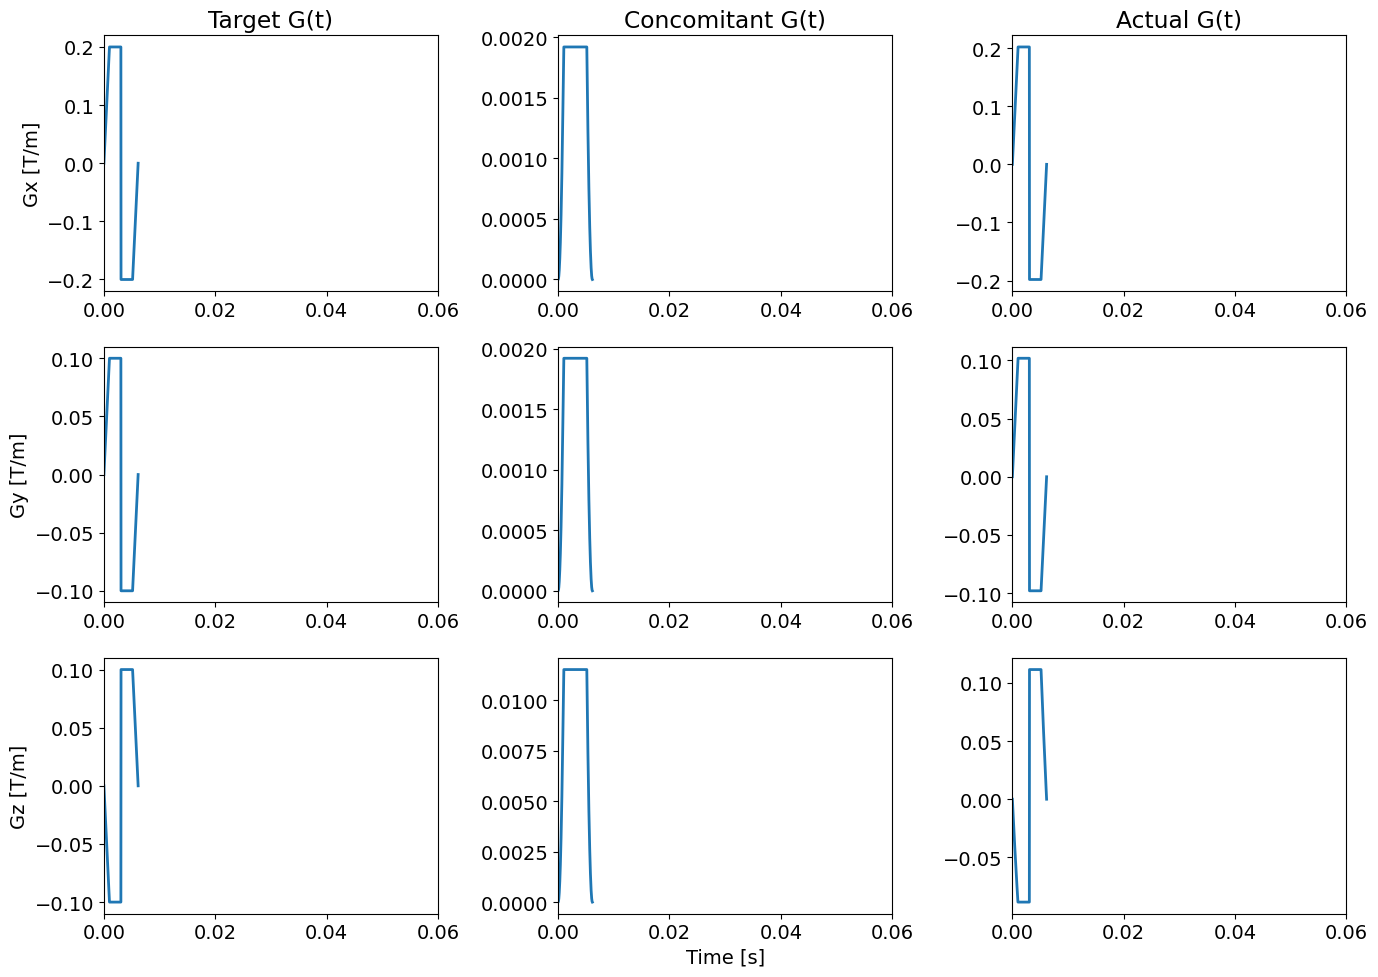

In [4]:
# Plot the target and "distorted" gradient waveforms
plt.rcParams.update({'lines.linewidth': 2, 'font.size': 14})
fig, axs = plt.subplots(3, 3, figsize=(14, 10))
# tvec = tvec

# X-gradient axis
axs[0, 0].plot(tvec, G_0[0, :])
axs[0, 0].set_title('Target G(t)'); axs[0, 0].set_ylabel('Gx [T/m]'); axs[0, 0].set_xlim([0, 0.06])
axs[0, 1].plot(tvec, dGC[0, :])
axs[0, 1].set_title('Concomitant G(t)'); axs[0, 1].set_xlim([0, 0.06])
axs[0, 2].plot(tvec, G_C[0, :])
axs[0, 2].set_title('Actual G(t)'); axs[0, 2].set_xlim([0, 0.06])

# Y-gradient axis
axs[1, 0].plot(tvec, G_0[1, :])
axs[1, 0].set_ylabel('Gy [T/m]'); axs[1, 0].set_xlim([0, 0.06])
axs[1, 1].plot(tvec, dGC[1, :]); axs[1, 1].set_xlim([0, 0.06])
axs[1, 2].plot(tvec, G_C[1, :]); axs[1, 2].set_xlim([0, 0.06])

# Z-gradient axis
axs[2, 0].plot(tvec, G_0[2, :])
axs[2, 0].set_ylabel('Gz [T/m]'); axs[2, 0].set_xlim([0, 0.06])
axs[2, 1].plot(tvec, dGC[2, :]); axs[2, 1].set_xlabel('Time [s]'); axs[2, 1].set_xlim([0, 0.06])
axs[2, 2].plot(tvec, G_C[2, :]); axs[2, 2].set_xlim([0, 0.06])

plt.tight_layout()
plt.show()

In [5]:
## Compute the effective b-values with concomitant gradients
# Compute the b-value numerically by integrating the gradient over time
GXcg = np.cumsum(G_C[0, :]) * dt  # ∫ g(τ) dτ
GYcg = np.cumsum(G_C[1, :]) * dt  # ∫ g(τ) dτ
GZcg = np.cumsum(G_C[2, :]) * dt  # ∫ g(τ) dτ

# Square and integrate again
bXcg = gamma**2 * np.sum(GXcg**2) * dt * 1e-6 # ∫ (∫g)^2 dt; Convert from [s/m^2] to [s/mm^2]
bYcg = gamma**2 * np.sum(GYcg**2) * dt * 1e-6 # ∫ (∫g)^2 dt; Convert from [s/m^2] to [s/mm^2]
bZcg = gamma**2 * np.sum(GZcg**2) * dt * 1e-6 # ∫ (∫g)^2 dt; Convert from [s/m^2] to [s/mm^2]
b_cg_amp = np.linalg.norm([bXcg, bYcg, bZcg])

print(f"bXcg: {bXcg:.2f} s/mm^2")
print(f"bYcg: {bYcg:.2f} s/mm^2")
print(f"bZcg: {bZcg:.2f} s/mm^2")
print(f"b_cg: {b_cg_amp:.2f} s/mm^2")

# Output the b-value components...
print("  ")
print(f"b_x: {b_val[0]:.2f} s/mm^2")
print(f"b_y: {b_val[1]:.2f} s/mm^2")
print(f"b_z: {b_val[2]:.2f} s/mm^2")
print(f"b = {b_amp:.2f} s/mm^2")

bXcg: 33.04 s/mm^2
bYcg: 8.49 s/mm^2
bZcg: 5.93 s/mm^2
b_cg: 34.63 s/mm^2
  
b_x: -971.54 s/mm^2
b_y: -242.89 s/mm^2
b_z: -242.89 s/mm^2
b = 1030.48 s/mm^2


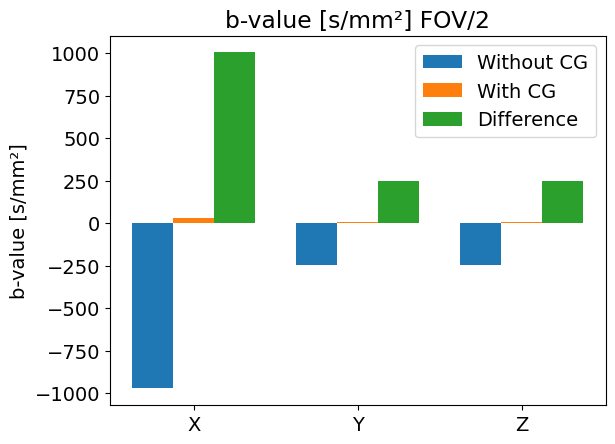

In [6]:
# Bar plot
y = np.array([
    [b_val[0], bXcg, abs(bXcg - b_val[0])],
    [b_val[1], bYcg, abs(bYcg - b_val[1])],
    [b_val[2], bZcg, abs(bZcg - b_val[2])]
])

fig, ax = plt.subplots()
bar_labels = ['X', 'Y', 'Z']
x = np.arange(len(bar_labels))
width = 0.25
ax.bar(x - width, y[:, 0], width, label='Without CG')
ax.bar(x, y[:, 1], width, label='With CG')
ax.bar(x + width, y[:, 2], width, label='Difference')
ax.set_ylabel('b-value [s/mm²]')
ax.set_xticks(x)
ax.set_xticklabels(bar_labels)
ax.set_title('b-value [s/mm²] FOV/2')
ax.legend()
plt.show()